# Working memory task

<div>
    <p align="left"><img src="images/wm_task.png" width = '200px'> 
        <ol style="padding-left:240px">
        <li>Participants are presented with patterns that they have to reproduce.</li>
        <li>Three trial types:
            <ul>
                <li>No distractor (this condition is duplicated)</li>
                <li>Encoding distractor (distractor shown at the same time as pattern)</li>
                <li>Delayed distractor (distractor shown after pattern disappears)</li>
            </ul>
        </li>
        <li>For each trial type, participants first complete a pattern of three.</li>
            <ul>
                <li>If they fail they move to two, if they fail again the game finishes.</li>
                <li>For each condition the level increases with success.</li>
                <li>Condition ends when two consecutive wrong or 8 trials completed (implies maximum score of 10)</li>
            </ul>
    </ol>
    
   
    
</div>

In [ ]:
%load_ext autoreload
%autoreload 2
from trr265.gbe import GBEProvider

In [ ]:
dp = GBEProvider('/Users/hilmarzech/Projects/trr265/trr265/data/')

In [ ]:
@dp.get_efficiently
def get_initial_filtered_wm_data():
    '''This function preprocesses the working memory data.
    Note that this function already filters out participants that failed level 2 on any condition and participants that completed the wrong game.
    '''
    df = dp.get_gbe_baseline_data() # ToDo: add sample variable ("initial" vs. "replication")
    df = df[df.initial] # For now, we only look at the initial dataset
    df = df[df['WorkingMemoryGame'].isnull()==False]
    df = dp.decode_gbe_strings(df, "WorkingMemoryGame")
    df['success'] = df.success.astype(int)
    specs = get_wm_trial_specifications()
    df = df.merge(specs,on='trialid',validate='many_to_one').sort_values(by=['participant','baseline_session','trial_index']).reset_index(drop = True)
    df['trial_number'] = df.groupby(['participant','baseline_session','type']).cumcount()+1
    df['is_even'] = (df.trial_number+1)%2
    ## Filtering variables of interest
    wm_vars = ["timestarted", "timesubmitted", "success", "timetaken", "trialid","trial_number", "trialrot","is_even","pattern","level","type","boards"]
    df = df[['mov_index','gbe_index','gbe_baseline_index','initial','trial_index','participant','baseline_session']+wm_vars]
    # Filtering out participants that used an old version of the GBE
    is_sequential = (df.set_index('participant')['type']=='sequential').reset_index().groupby('participant').max()
    wrong_game_pps = list(is_sequential[is_sequential.type].index)
    print("%d participants used the wrong version of the game."%len(wrong_game_pps))
    df = df[df.participant.isin(wrong_game_pps)==False]
    # Filtering out participants that failed level two
    failed_level_two = df.query("(level==2) and (success==0)").gbe_baseline_index.unique()
    print("%d sessions are excluded because participants failed on a level two trial of any condition."%len(failed_level_two))
    df = df[df.gbe_baseline_index.isin(failed_level_two)==False]
    # Fixing the duplicated no distractor condition
    df['type'] = df.type.replace({"no_distractor_1":"no_distractor","no_distractor_2":"no_distractor"})
    type_repetitions = df[df.type.str.contains('no')].groupby(['participant','baseline_session']).apply(fix_game)
    type_repetitions.index.name = ""
    df['type_repetition'] = type_repetitions['type_repetition']
    df.type_repetition.fillna("",inplace = True)
    df['type'] = df.type + df.type_repetition
    df.drop(columns = 'type_repetition', inplace = True)
    return df

In [ ]:
class WMTask():
    def __init__(self, dp):
        self.dp = dp
        
wm_task = WMTask(dp)

In [ ]:
#%%capture
#%%R
#library(lme4)
#library(lmerTest)
#library(ggeffects)
#control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e5))  #mixed logistic regression

In [ ]:
# Defining getters for working memory data and participant data
wm_data_getter = get_initial_filtered_wm_data
session_data_getter = lambda: dp.get_gbe_baseline_data(columns = ['initial']).query('initial').loc[wm_data_getter().gbe_baseline_index.unique()]

# Example data

In [ ]:
def show_wm_data_example():
    '''This function shows example data from the working memory task.
    '''
    df = wm_data_getter()
    example = df.query("participant=='b154' and baseline_session=='Session 2' and type == 'encoding_distractor'")[['participant','baseline_session','trial_number','pattern','level','type','success']]
    display(example.reset_index(drop=True))

show_wm_data_example()

,participant,baseline_session,trial_number,pattern,level,type,success
0,b154,Session 2,1,TDTDT,3,encoding_distractor,0
1,b154,Session 2,2,TDTD,2,encoding_distractor,1
2,b154,Session 2,3,DTTTD,3,encoding_distractor,1
3,b154,Session 2,4,TTTTDD,4,encoding_distractor,1
4,b154,Session 2,5,TDDTTTT,5,encoding_distractor,1
5,b154,Session 2,6,DTDTTTTT,6,encoding_distractor,1
6,b154,Session 2,7,TTTTTTTDD,7,encoding_distractor,1
7,b154,Session 2,8,DTTDTTTTTT,8,encoding_distractor,1


# Gold standard - Maximum WM load per condition
"Performance in each condition was measured as the maximum WM load at which a trial was answered correctly. The maximum score for each condition was 10. The score from the ND condition was used as a measure of WMC." (McNab et al., 2015, p.6518)

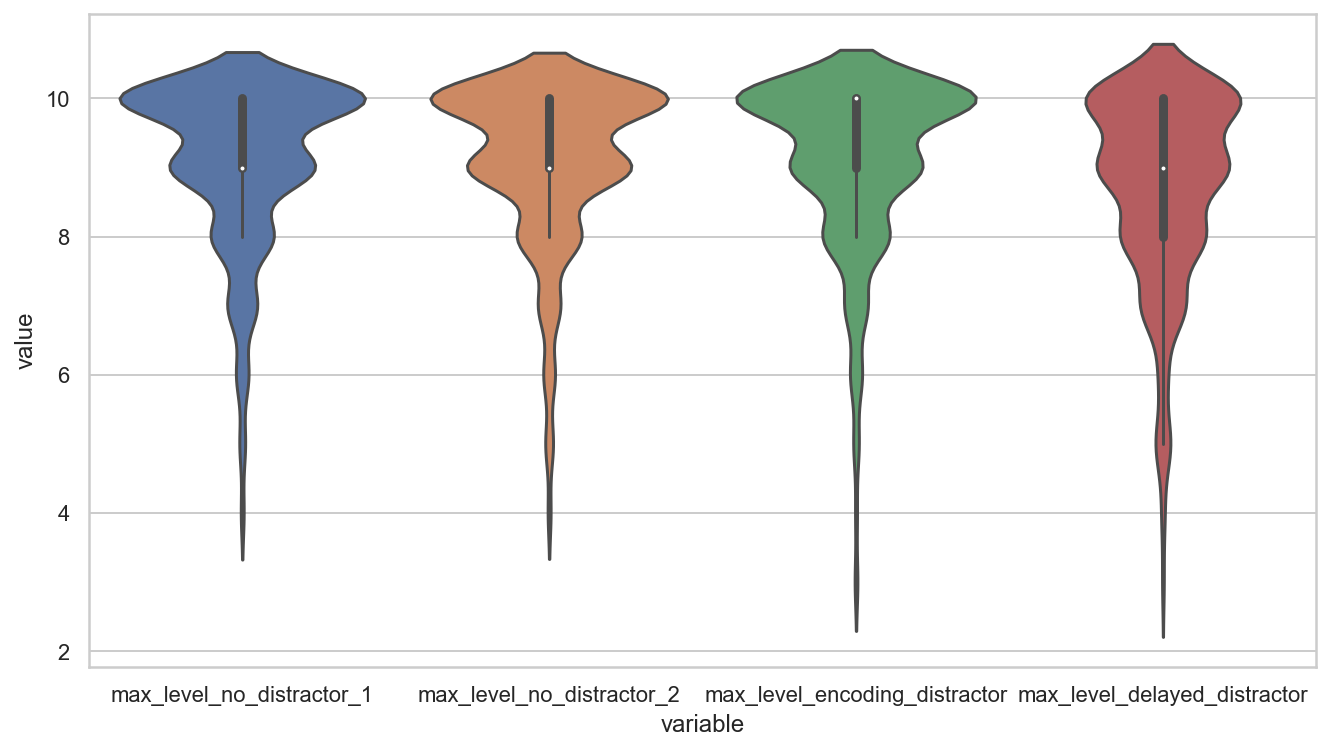

In [ ]:
def get_condition_max_levels(df):
    successful_trials = df[df.success==1]
    max_levels = successful_trials.groupby(['participant','baseline_session']).agg({'level':'max','gbe_baseline_index':'first'})
    max_levels.set_index('gbe_baseline_index', inplace = True)
    return max_levels

def get_max_levels():
    df = wm_data_getter()
    session_data = session_data_getter()
    #session_data = dp.get_gbe_baseline_data(columns = ['initial']).query('initial').loc[df.gbe_baseline_index.unique()] # Getting baseline data with associated WM data    
    session_data.drop(columns = ['initial'], inplace = True)
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        type_data = df.query('type=="%s"'%trial_type)
        session_data['max_level_%s'%trial_type] = get_condition_max_levels(type_data)
        session_data['max_level_%s'%trial_type].fillna(1, inplace = True)
    return session_data

def describe_max_level_distribution():
    max_levels = get_max_levels()
    sns.violinplot(x="variable", y="value", data=pd.melt(max_levels))
    for column in max_levels.columns:
        max_levels[column].utils.describe(description = 'The maximum in the "%s" condition'%' '.join(column.split('_')[2:]), unit = "points")
    
      
if __name__ == '__main__':
    describe_max_level_distribution()

# Simplified scores for trial-level analyses

## Percentage correct

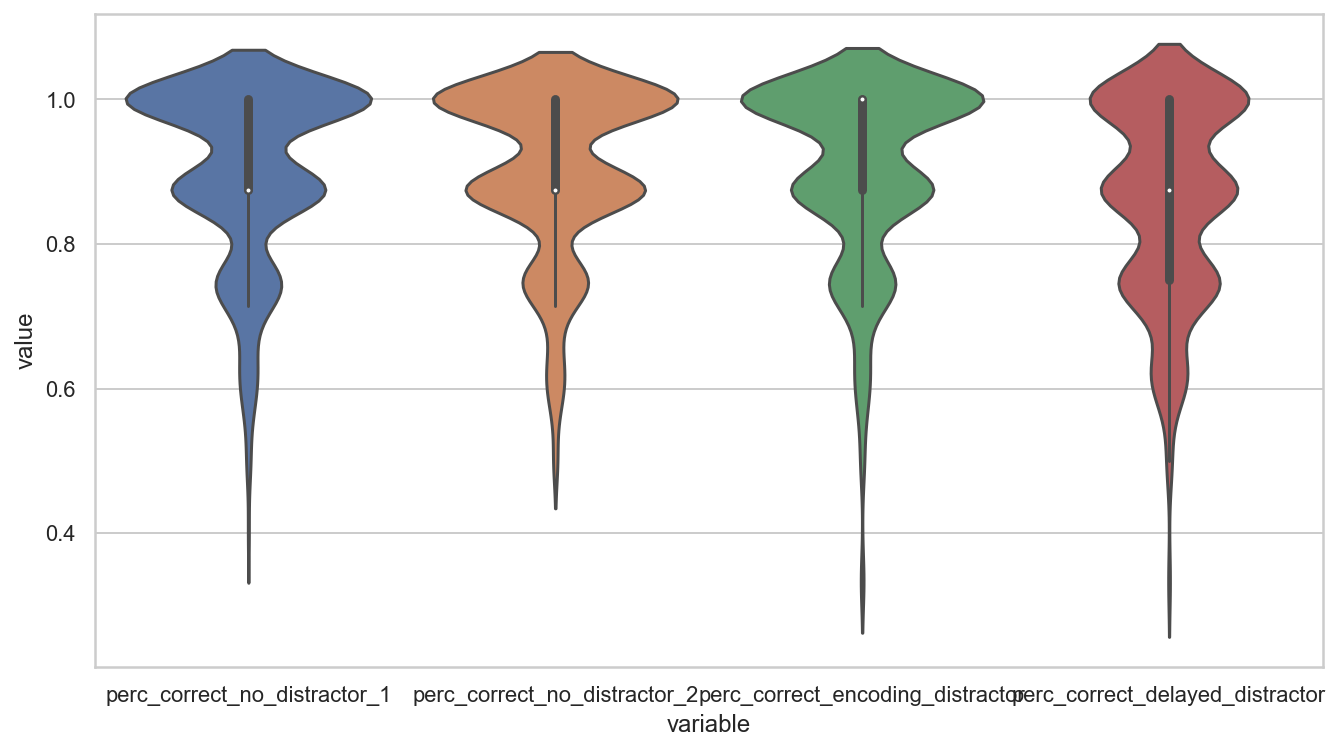

In [ ]:
def get_condition_percentage_correct(df):
    return df.groupby(['gbe_baseline_index']).success.mean()

def get_percentage_correct():
    df = wm_data_getter()
    session_data = session_data_getter()
    session_data.drop(columns = ['initial'], inplace = True)
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        type_data = df.query('type=="%s"'%trial_type)
        session_data['perc_correct_%s'%trial_type] = get_condition_percentage_correct(type_data)
        session_data['perc_correct_%s'%trial_type].fillna(1, inplace = True)
    return session_data

def describe_perc_correct_distribution():
    perc_correct = get_percentage_correct()
    sns.violinplot(x="variable", y="value", data=pd.melt(perc_correct))
    for column in perc_correct.columns:
        (perc_correct[column]*100).utils.describe(description = 'The percentage correct in the "%s"'%' '.join(column.split('_')[2:]), unit = "percent")
    
      
if __name__ == '__main__':
    describe_perc_correct_distribution()

### Correlation with gold standard

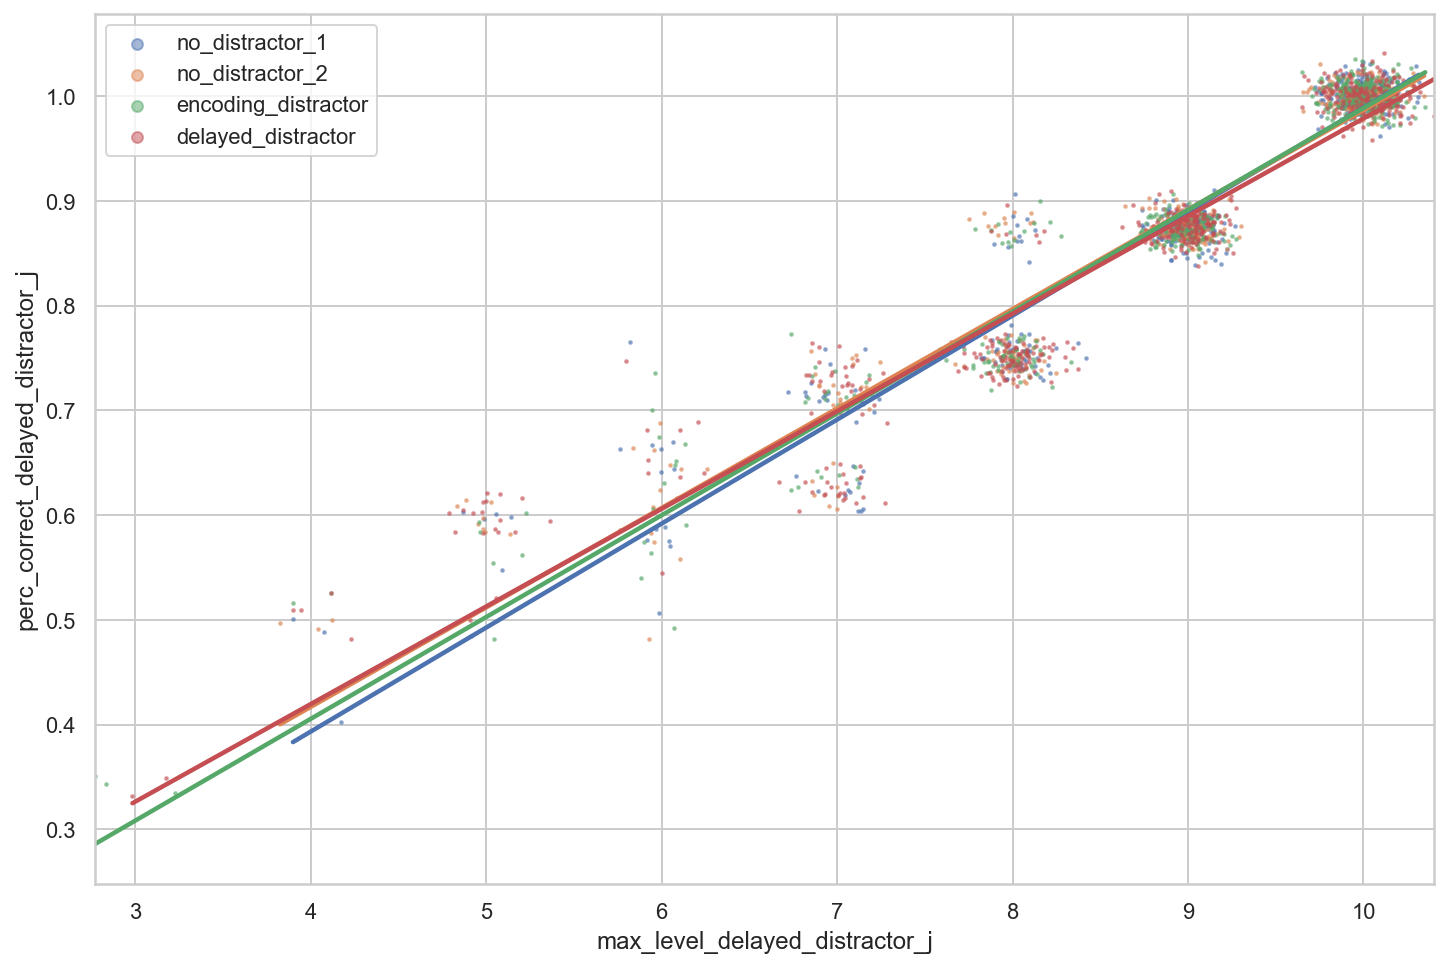

In [ ]:
def jitter(arr):
    return arr + np.random.randn(len(arr)) * arr.std()/10

def jittered_regplot(**kwargs):
    df, x, y = kwargs['data'],kwargs['x'], kwargs['y']
    
    df[x+'_j'] = jitter(df[x])
    df[y+'_j'] = jitter(df[y])
    kwargs['x'] = x+'_j'
    kwargs['y'] = y+'_j'
    kwargs['data'] = df
    ax = sns.regplot(**kwargs)
    
    return ax

def show_max_score_percentage_correlation():
    df = get_percentage_correct().merge(get_max_levels(), left_index = True, right_index = True)
    fix, ax = plt.subplots(1,1, figsize = (12,8))
    
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        jittered_regplot(x = 'max_level_%s'%trial_type, y = 'perc_correct_%s'%trial_type, data = df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
    lgnd = plt.legend()
    for i in range(4):
        lgnd.legendHandles[i]._sizes = [30]
show_max_score_percentage_correlation()

The correlation between the two scores is very high. However, there are some systematic differences.  For example, here are two sessions with 50% correct answers, but differing in max WMC level (4 vs. 6).

### Examples of systematic differences with gold standard

In [ ]:
def analyze_systematic_differences():
    df = get_percentage_correct().merge(get_max_levels(), left_index = True, right_index = True)
    example_session_1 = df.query('(max_level_no_distractor_1==6) and (perc_correct_no_distractor_1==.5) ').index[0]
    display(get_initial_filtered_wm_data().query('gbe_baseline_index==%s'%example_session_1).query("type == 'no_distractor_1'")[['level','success']])
    example_session_2 = df.query('max_level_no_distractor_1==4').index[0]
    display(get_initial_filtered_wm_data().query('gbe_baseline_index==%s'%example_session_2).query("type == 'no_distractor_1'")[['level','success']])
analyze_systematic_differences()

,level,success
2655,3,1
2657,4,0
2660,4,1
2667,5,1
2669,6,0
2676,6,1
2680,7,0
2683,7,0


,level,success
1247,3,1
1252,4,1
1255,5,0
1260,5,0


### Trial-level analysis

In [ ]:
def test():
    df = wm_data_getter()
    session_data = session_data_getter()
    session_data.drop(columns = ['initial'], inplace = True)
    r_data = df[['gbe_baseline_index','participant','baseline_session','type','success']]
    display(r_data)
test()

,gbe_baseline_index,participant,baseline_session,type,success
0,0,b001,Session 1,delayed_distractor,1
1,0,b001,Session 1,encoding_distractor,1
2,0,b001,Session 1,no_distractor_1,1
3,0,b001,Session 1,no_distractor_2,1
4,0,b001,Session 1,no_distractor_1,1
...,...,...,...,...,...
17178,488,m205,Session 2,delayed_distractor,0
17179,488,m205,Session 2,encoding_distractor,1
17180,488,m205,Session 2,no_distractor_2,0
17181,488,m205,Session 2,encoding_distractor,1


R[write to console]: boundary (singular) fit: see ?isSingular



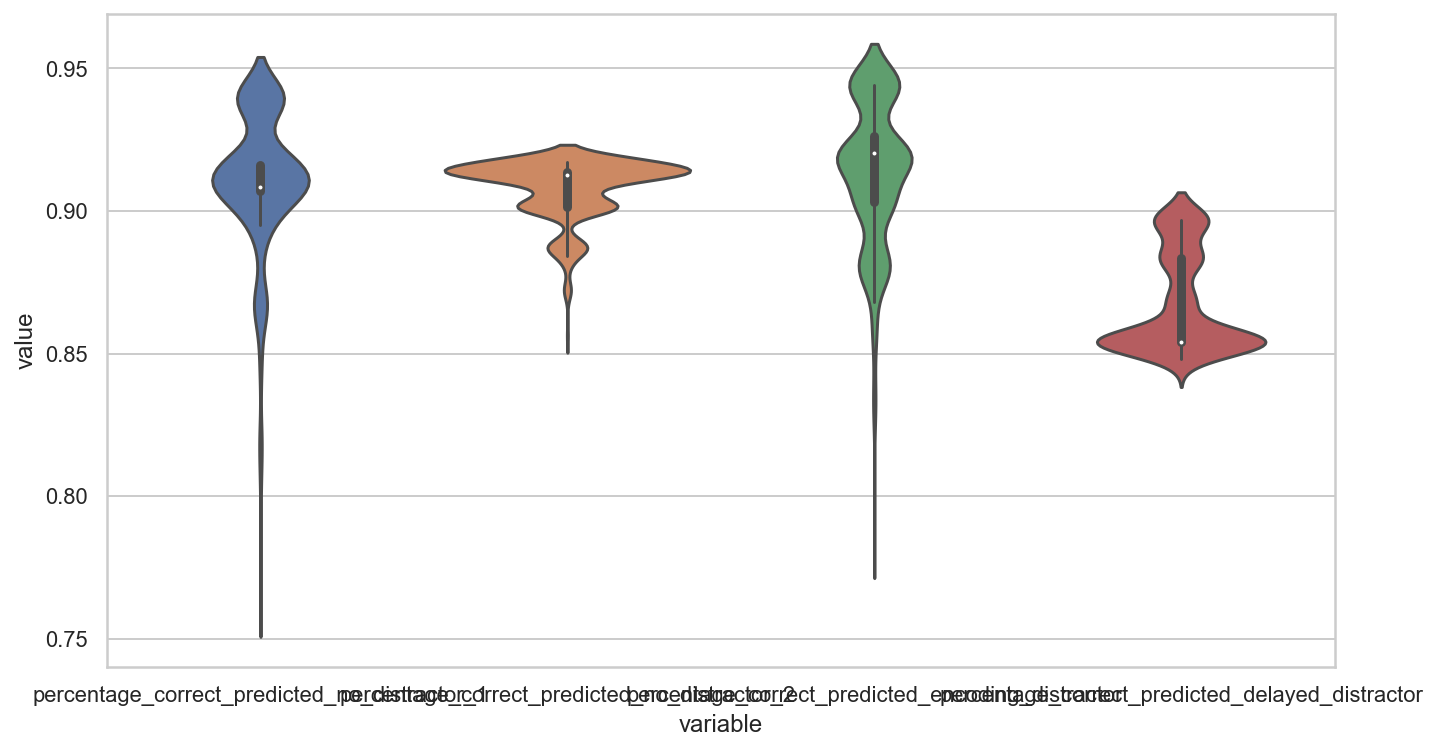

In [ ]:
def get_condition_percentage_correct_predicted(df):
    s1 = df.query('baseline_session == "Session 1"')
    s2 = df.query('baseline_session == "Session 2"')
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))  #mixed logistic regression
    %R m1 = glmer(success ~ 1 + (1 | participant), data=s1, family=binomial, control = control, na.action = na.exclude) -i s1
    %R m2 = glmer(success ~ 1 + (1 | participant), data=s2, family=binomial, control = control, na.action = na.exclude) -i s2
    %R p1 <- ggpredict(m1, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p1
    %R p2 <- ggpredict(m2, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p2
    p1.columns = ['participant','predicted','baseline_session']
    p2.columns = ['participant','predicted','baseline_session']
    p1['baseline_session'] = 'Session 1'
    p2['baseline_session'] = 'Session 2'
    predicted = pd.concat([p1,p2], ignore_index = True)
    # This line is ugly (all it does is bring the data back to the gbe_baseline_index)
    predicted = pd.merge(predicted, df.groupby(['participant','baseline_session'])['gbe_baseline_index'].first().reset_index(), on = ['participant','baseline_session'], how='inner', validate='one_to_many').set_index('gbe_baseline_index')['predicted']
    return predicted

def get_percentage_correct_predicted():
    df = wm_data_getter()
    session_data = session_data_getter()
    session_data.drop(columns = ['initial'], inplace = True)
    r_data = df[['gbe_baseline_index','participant','baseline_session','type','success']]
    r_data['session'] = r_data.baseline_session.apply(lambda x: int(x.split(' ')[1]))

    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        type_data = r_data.query('type=="%s"'%trial_type)
        session_data['percentage_correct_predicted_%s'%trial_type] = get_condition_percentage_correct_predicted(type_data)
    return session_data

def describe_predicted_perc_correct_distribution():
    perc_correct = get_percentage_correct_predicted()
    sns.violinplot(x="variable", y="value", data=pd.melt(perc_correct))
    for column in perc_correct.columns:
        (perc_correct[column]*100).utils.describe(description = 'The percentage correct in the "%s"'%' '.join(column.split('_')[2:]), unit = "percent")
    
      
if __name__ == '__main__':
    describe_predicted_perc_correct_distribution()

R[write to console]: boundary (singular) fit: see ?isSingular



no_distractor_1
no_distractor_2
encoding_distractor
delayed_distractor


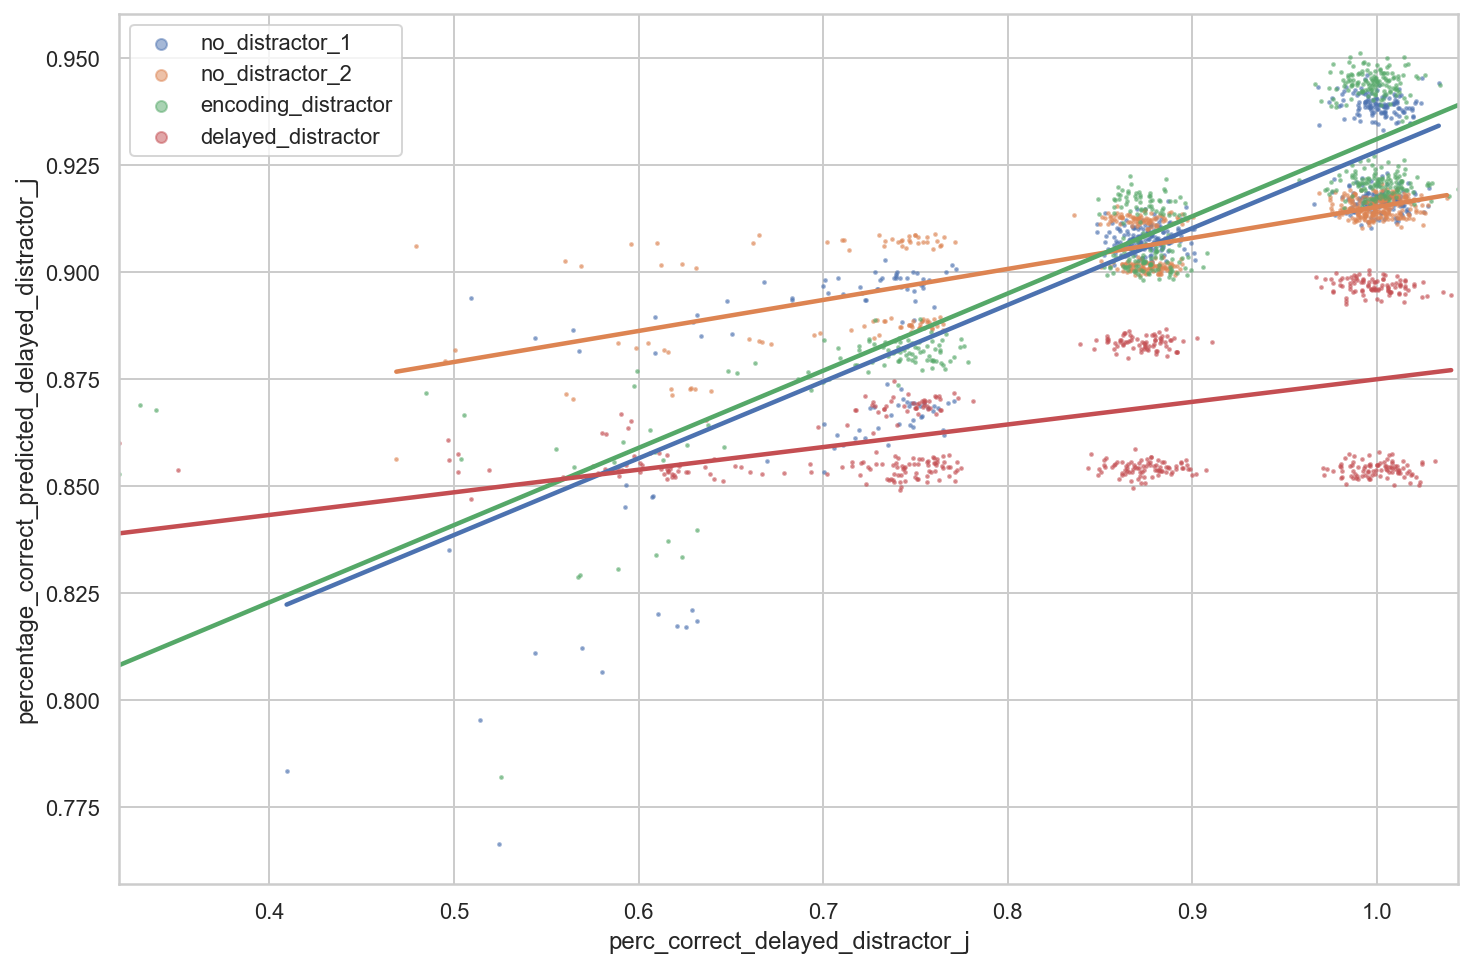

In [ ]:
# Correlation plots below do not match this plot, there must be a bug somewhere
def show_max_score_predicted_percentage_correlation():
    df = get_percentage_correct_predicted().merge(get_percentage_correct(), left_index = True, right_index = True)
    fix, ax = plt.subplots(1,1, figsize = (12,8))
    
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        print(trial_type)
        jittered_regplot(x = 'perc_correct_%s'%trial_type, y = 'percentage_correct_predicted_%s'%trial_type, data = df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
    lgnd = plt.legend()
    for i in range(4):
        lgnd.legendHandles[i]._sizes = [30]
show_max_score_predicted_percentage_correlation()

## Implied percentage correct
Here the differences look less systematic.

In [ ]:
def get_condition_implied_percentage_correct(df):
    df['duplication'] = df.groupby(['participant','baseline_session','type','level']).cumcount()
    test = df.set_index(['participant','baseline_session','type','level','duplication']).sort_index()[['success']]#.loc[('b001','Session 1')]
    levels = list(range(3,11))
    ## THIS LINE INTRODUCES NON EXISTING SESSIONS
    new_index = pd.MultiIndex.from_product([test.reset_index().participant.unique(), ['Session 1','Session 2'],test.reset_index().type.unique(), levels, [0,1]],names = ['participant','baseline_session','type','level','duplication'])
    test = test.reindex(new_index)
    test['implied_success'] = test.groupby(level=['participant','baseline_session','type','level']).transform(np.max).fillna(0)
    test['implied_success'] = test.success.fillna(test.implied_success)
    test = test.reset_index()
    test['implied_success'] = test.implied_success# * test.level
    test = test.merge(df.groupby(['participant','baseline_session']).gbe_baseline_index.first().reset_index(), on = ['participant','baseline_session'], how = 'outer' )
    test = test[test.gbe_baseline_index.isnull()==False]
    implied_success = test.groupby(['gbe_baseline_index']).implied_success.mean()
    return implied_success, test

def get_implied_percentage_correct():
    df = wm_data_getter()
    session_data = dp.get_gbe_baseline_data(columns = ['initial']).query('initial').loc[df.gbe_baseline_index.unique()] # Getting baseline data with associated WM data    
    session_data.drop(columns = ['initial'], inplace = True)
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        type_data = df.query('type=="%s"'%trial_type)
        session_data['impl_perc_correct_%s'%trial_type], _ = get_condition_implied_percentage_correct(type_data)
        session_data['impl_perc_correct_%s'%trial_type].fillna(1, inplace = True)
    return session_data

### Correlation with gold standard

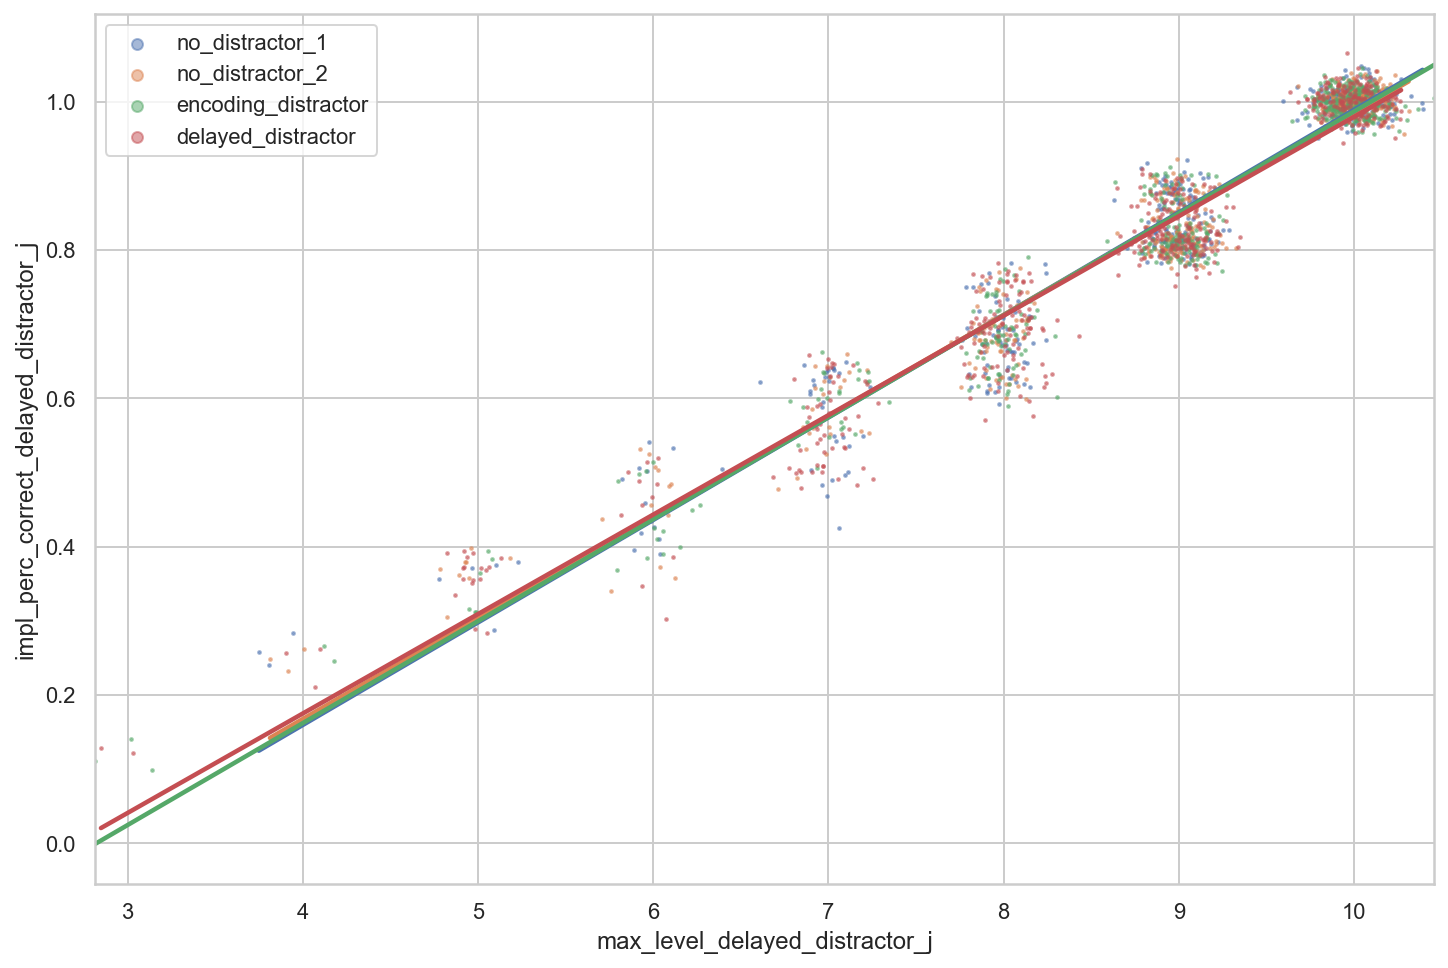

In [ ]:
def show_max_score_implied_percentage_correlation():
    df = get_implied_percentage_correct().merge(get_max_levels(), left_index = True, right_index = True)
    fix, ax = plt.subplots(1,1, figsize = (12,8))
    
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        jittered_regplot(x = 'max_level_%s'%trial_type, y = 'impl_perc_correct_%s'%trial_type, data = df, ci = None, label = trial_type,scatter_kws = {'s':2, 'alpha':.5})
    lgnd = plt.legend()
    for i in range(4):
        lgnd.legendHandles[i]._sizes = [30]
show_max_score_implied_percentage_correlation()

### Systematic differences with gold standard
Both these examples have the same WM level (6) and percentage correct (50%), however one has an implied percentage correct of .38 and one of .50.  The reason for this difference is that the standard maximum WMC scores get punished less by failed trials than the implied percentage correct.  We could fix this by only considering the second trial in each score, but this would make the mixed model singular as all scores can be perfectly represented in one score.

In [ ]:
def analyze_systematic_implied_differences():
    df = get_implied_percentage_correct().merge(get_max_levels(), left_index = True, right_index = True)
    example_session_1 = df.query('(max_level_no_distractor_1==6) and (impl_perc_correct_no_distractor_1<.4) ').index[0]
    #display(get_initial_filtered_wm_data().query('gbe_baseline_index==%s'%example_session_1).query("type == 'no_distractor_1'")[['level','success']])
    _, implied_data_1 = get_condition_implied_percentage_correct(get_initial_filtered_wm_data().query('gbe_baseline_index==%s'%example_session_1).query("type == 'no_distractor_1'"))
    print("The implied success in the following session was %.2f"%implied_data_1.implied_success.mean())
    display(implied_data_1[['level','success','implied_success']])
    example_session_2 = df.query('(max_level_no_distractor_1==6) and (impl_perc_correct_no_distractor_1>.4) ').index[0]
    _, implied_data_2 = get_condition_implied_percentage_correct(get_initial_filtered_wm_data().query('gbe_baseline_index==%s'%example_session_2).query("type == 'no_distractor_1'"))
    print("The implied success in the following session was %.2f"%implied_data_2.implied_success.mean())
    display(implied_data_2[['level','success','implied_success']])
analyze_systematic_implied_differences()

The implied success in the following session was 0.38


,level,success,implied_success
16,3,1.0,1.0
17,3,NaN,1.0
18,4,0.0,0.0
19,4,1.0,1.0
20,5,1.0,1.0
21,5,NaN,1.0
22,6,0.0,0.0
23,6,1.0,1.0
24,7,0.0,0.0
25,7,0.0,0.0


The implied success in the following session was 0.50


,level,success,implied_success
16,3,1.0,1.0
17,3,NaN,1.0
18,4,1.0,1.0
19,4,NaN,1.0
20,5,1.0,1.0
21,5,NaN,1.0
22,6,1.0,1.0
23,6,NaN,1.0
24,7,0.0,0.0
25,7,0.0,0.0


# Correlations between all (candidate) scores
ToDo: Split by variable type.

R[write to console]: boundary (singular) fit: see ?isSingular



no_distractor_1
no_distractor_2
encoding_distractor
delayed_distractor


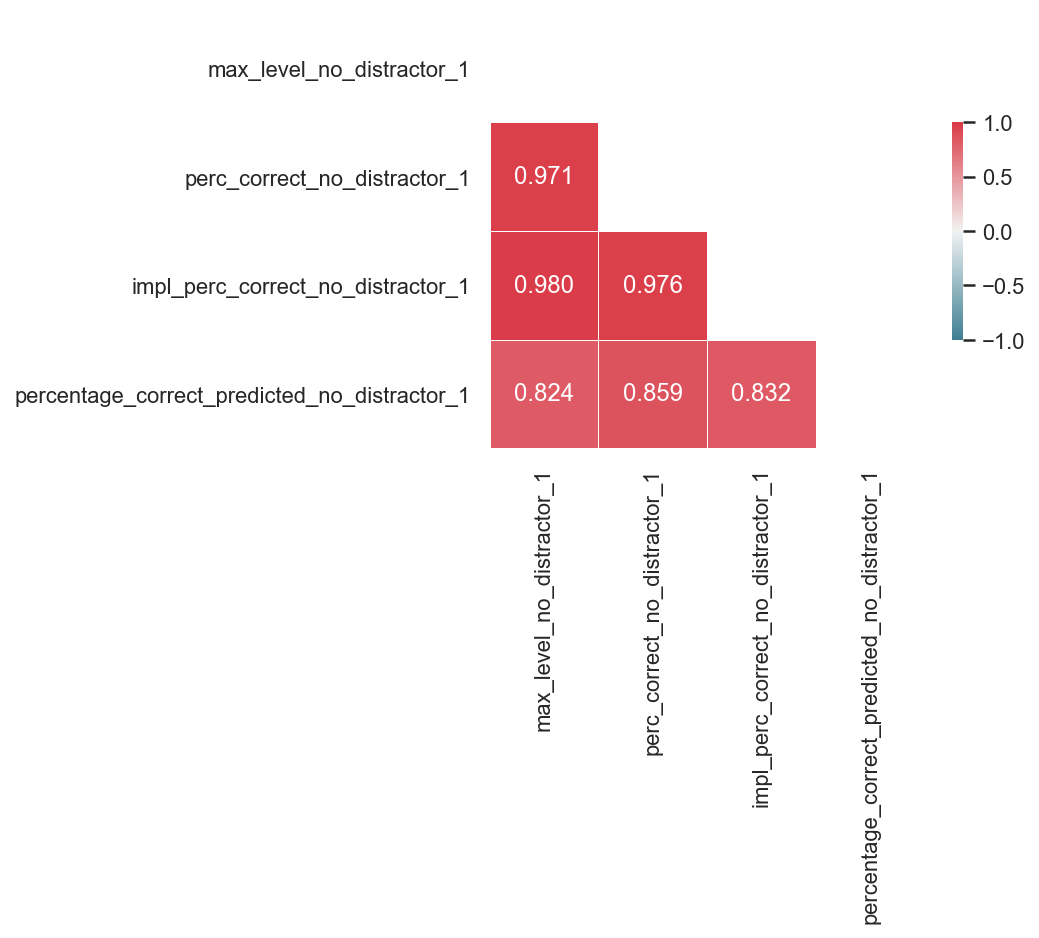

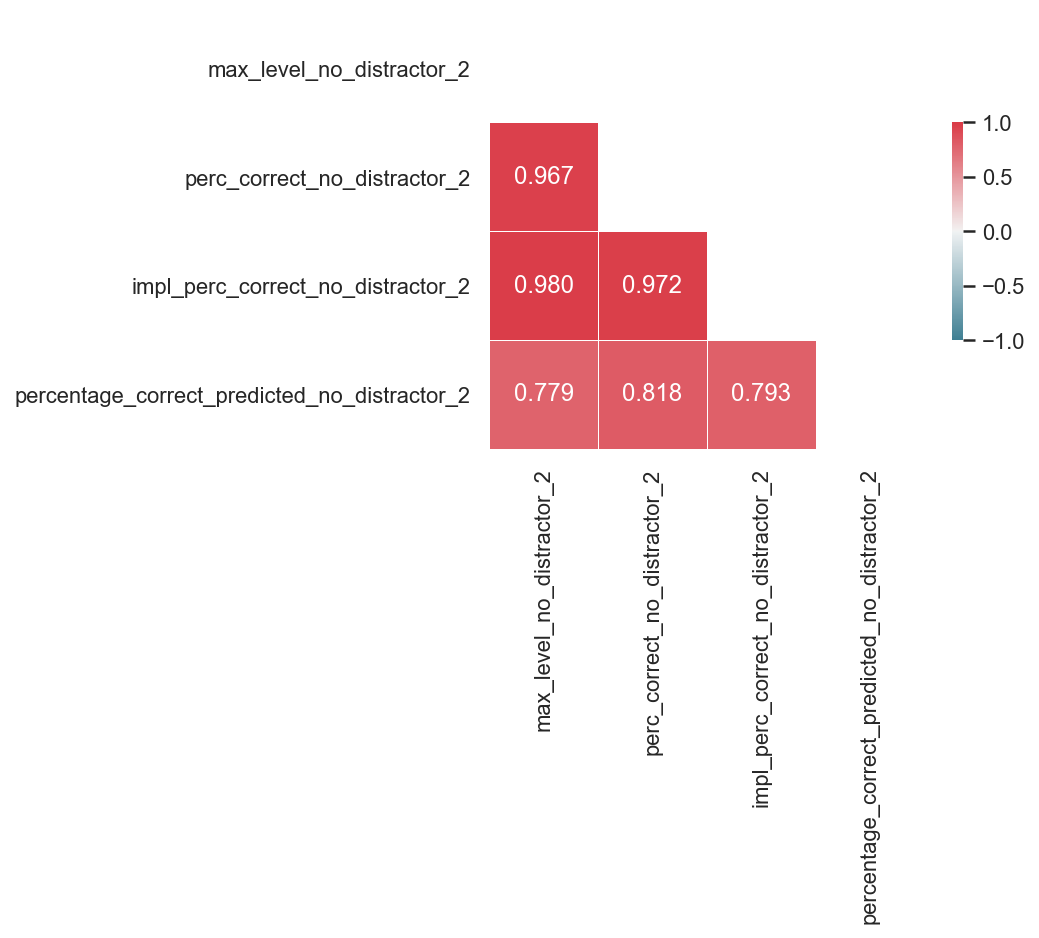

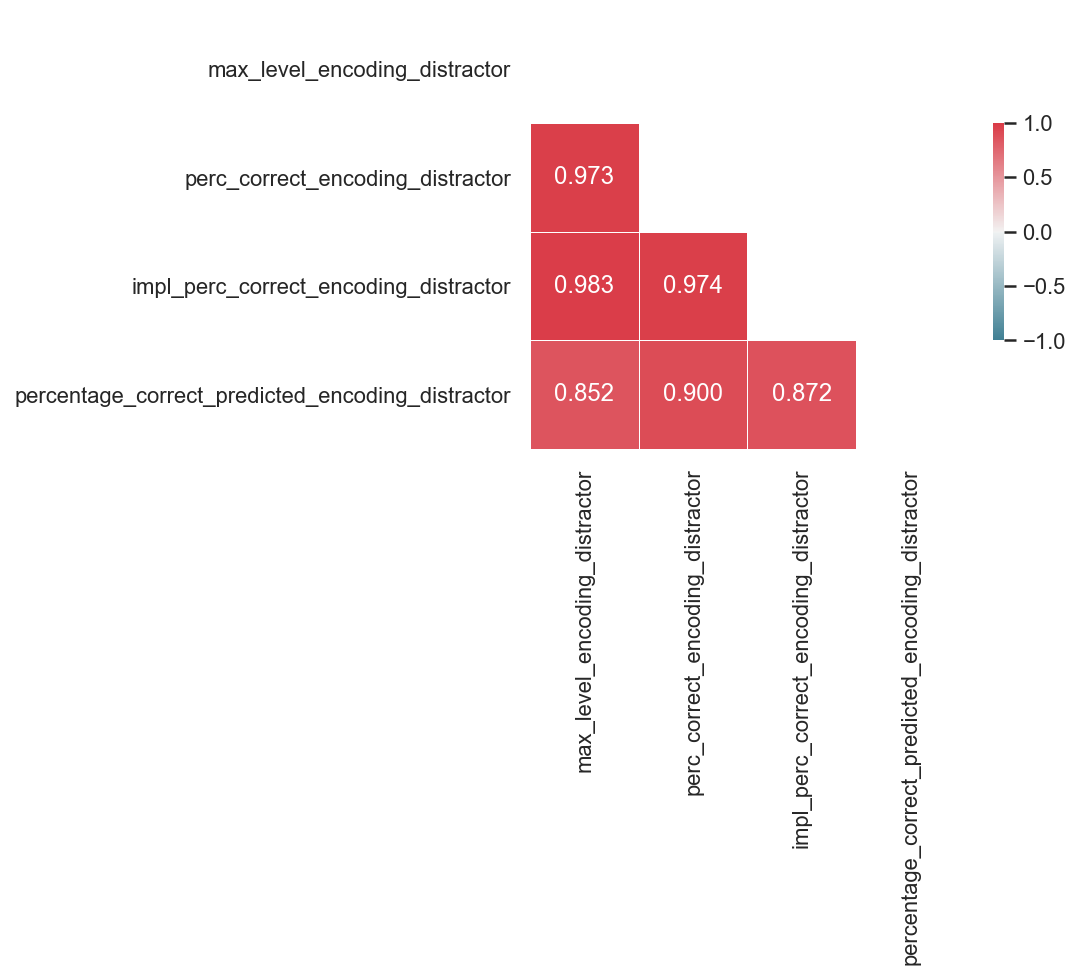

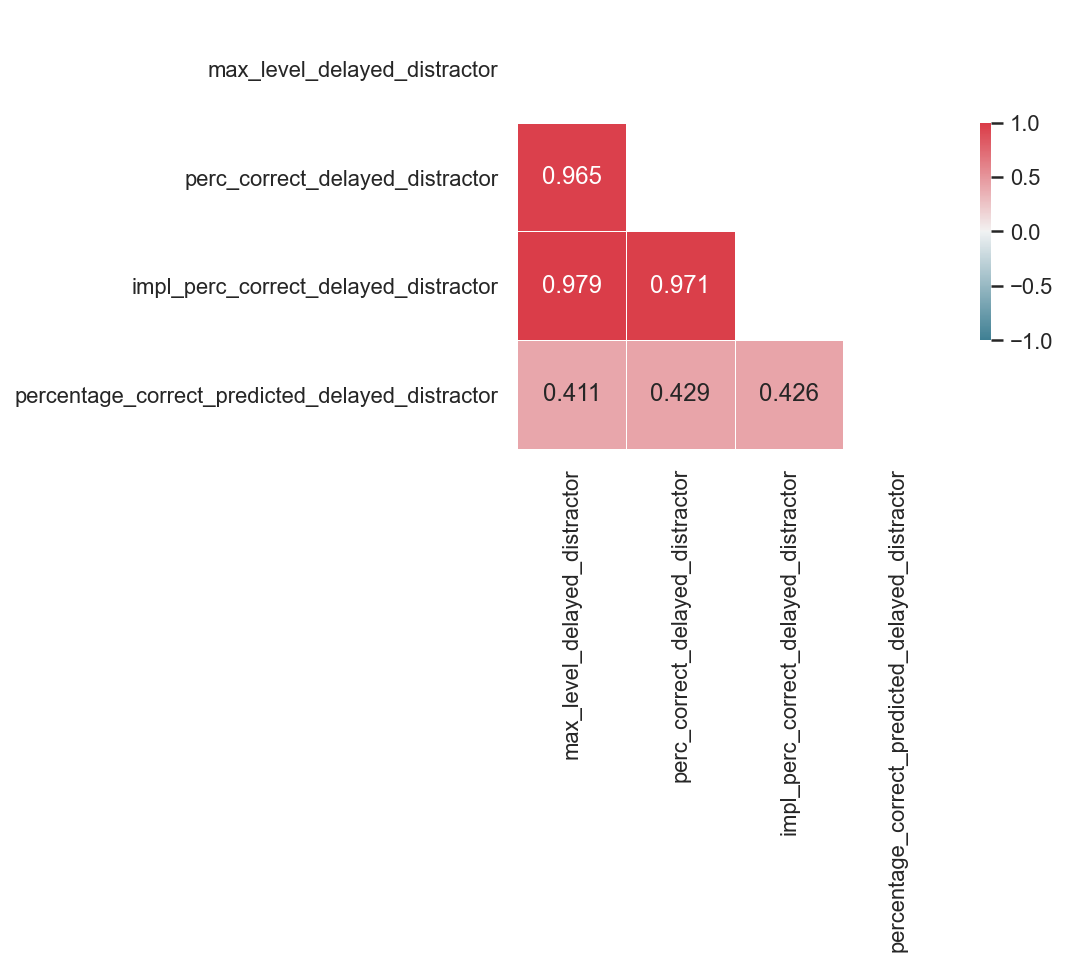

In [ ]:
def show_correlations():
    df = get_max_levels().merge(get_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_implied_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_percentage_correct_predicted(), left_index = True, right_index = True)
    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        print(trial_type)
        type_columns =[c for c in df.columns if trial_type in c]
        plotting.correlation_matrix(df[type_columns], size = (5,4))
show_correlations()

In [ ]:
def display_correlation():
    df = get_max_levels().merge(get_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_implied_percentage_correct(), left_index = True, right_index = True)
    df = df.merge(get_percentage_correct_predicted(), left_index = True, right_index = True)
    correlation_matrix(df, size = (15,12))

# ToDO

## Get stan to run

In [ ]:
def get_condition_percentage_correct_predicted_bayesian(df):
    s1 = df.query('baseline_session == "Session 1"')
    display(s1)
    s2 = df.query('baseline_session == "Session 2"')
    %R control=glmerControl(optimizer = "bobyqa", optCtrl=list(maxfun=1e6))  #mixed logistic regression
    %R library(rstanarm)
    %R m1 = stan_glmer(success ~ 1 + (1 | participant), data=s1, family=binomial, na.action = na.exclude) -i s1
    %R m2 = stan_glmer(success ~ 1 + (1 | participant), data=s2, family=binomial, na.action = na.exclude) -i s2
    %R p1 <- ggpredict(m1, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p1
    %R p2 <- ggpredict(m2, terms=c("participant[all]"), type="re",ci.lvl = NA) -o p2
    p1.columns = ['participant','predicted','baseline_session']
    p2.columns = ['participant','predicted','baseline_session']
    p1['baseline_session'] = 'Session 1'
    p2['baseline_session'] = 'Session 2'
    predicted = pd.concat([p1,p2], ignore_index = True)
    # This line is ugly (all it does is bring the data back to the gbe_baseline_index)
    predicted = pd.merge(predicted, df.groupby(['participant','baseline_session'])['gbe_baseline_index'].first().reset_index(), on = ['participant','baseline_session'], how='inner', validate='one_to_many').set_index('gbe_baseline_index')['predicted']
    return predicted

def get_percentage_correct_predicted_bayesian():
    df = wm_data_getter()
    session_data = session_data_getter()
    session_data.drop(columns = ['initial'], inplace = True)
    r_data = df[['gbe_baseline_index','participant','baseline_session','type','success']]
    r_data['session'] = r_data.baseline_session.apply(lambda x: int(x.split(' ')[1]))

    for trial_type in ['no_distractor_1','no_distractor_2','encoding_distractor','delayed_distractor']:
        type_data = r_data.query('type=="%s"'%trial_type)
        session_data['percentage_correct_predicted_%s'%trial_type] = get_condition_percentage_correct_predicted_bayesian(type_data)
    return session_data

def describe_predicted_perc_correct_distribution_bayesian():
    perc_correct = get_percentage_correct_predicted()
    sns.violinplot(x="variable", y="value", data=pd.melt(perc_correct))
    for column in perc_correct.columns:
        (perc_correct[column]*100).utils.describe(description = 'The percentage correct in the "%s"'%' '.join(column.split('_')[2:]), unit = "percent")
    
      
#describe_predicted_perc_correct_distribution_bayesian()